# Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm.auto import tqdm
import os
from sklearn.metrics import accuracy_score
from time import sleep

## For Google Colab Users

This cell is for mounting your Google Drive to the Colab Notebook. If you are not using Google Colab, you can skip this cell

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# Check for GPU
# device = "cuda" if torch.cuda.is_available() else "cpu"

# Check for GPU in mac
device = "mps" if torch.backends.mps.is_available() else "cpu"

device

'mps'

# Data 

## Transforming Data

In [3]:
data_transforms = {
    'Training' : transforms.Compose([
        transforms.RandomResizedCrop((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'Testing': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
}

## Loading Data

In [4]:
base_path = os.getcwd()
data_dir = os.path.join(base_path, 'dataset')

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['Training', 'Testing']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True) for x in ['Training', 'Testing']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['Training', 'Testing']}
class_names = image_datasets['Training'].classes


dataset_sizes, class_names

({'Training': 2770, 'Testing': 394},
 ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'])

## Samples of data

In [ ]:
samples, labels = next(iter(dataloaders['Testing']))
plt.figure(figsize=(17, 10))
plt.axis('off')
for i in range(32):
    plt.subplot(4, 8, i+1)
    plt.imshow(samples[i].permute(1, 2, 0))
    plt.title(class_names[labels[i]])
    plt.axis('off')

/var/folders/bd/4lflpjc116l_jkfv7vy18qkw0000gn/T/ipykernel_8784/1199029542.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4, 8, i+1)


# Model

## Loading Model

In [5]:
# Loading pretrained model
model = models.resnet50(weights='IMAGENET1K_V2')
for param in model.parameters():
    param.requires_grad = False

for param in model.layer4.parameters():
    param.requires_grad = True
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Preparing Model

In [6]:
model.fc = nn.Sequential(
    nn.Flatten(),
    nn.Dropout(0.5),
    nn.Linear(2048, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 10),
    nn.Softmax(dim=1),
)
model = model.to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Training

## Loss function

In [10]:
criterion = nn.CrossEntropyLoss()

## Optimizer

In [7]:
optimizer = optim.Adam([
    {'params': model.layer4.parameters(), 'lr': 0.001},
    {'params': model.fc.parameters(), 'lr': 0.01, 'weight_decay': 0.05},
])

## Others

In [23]:
# you can have other thongs like learning rate scheduler and ...
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.7)

## Train

In [32]:
def calc_test_acc(model):
  data = 'Testing'
  corrects = 0

  model.eval()
  for inputs, labels in dataloaders[data]:
      inputs = inputs.to(device)
      labels = labels.to(device)
      
      with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, dim=1)
        corrects += torch.sum(preds == labels.data)
  return corrects.float() / dataset_sizes[data]

In [23]:
losses = []
EPOCH = 12
max_validation_accuracy = 0
best_model = model

# loop on epochs
for e in tqdm(range(EPOCH)):

  # loop on batches
  batch = 0
  epoch_loss = 0
  accuracy = 0
  model.train()
  for inputs, labels in dataloaders['Training']:
    inputs = inputs.to(device)
    labels = labels.to(device)

    # set the grad to zero
    optimizer.zero_grad()
    
    # forward part
    # hint: using of pytorch max method (https://pytorch.org/docs/stable/generated/torch.max.html)
    outputs = model(inputs)
    _, preds = torch.max(outputs, dim=1)
    
    #  compute loss
    loss = criterion(outputs, labels)
    
    # backward part
    loss.backward()

    # update parameters
    optimizer.step()
    batch_accuracy = accuracy_score(preds.cpu(), labels.cpu())
    accuracy += batch_accuracy
    print(f'accuracy = {batch_accuracy}   loss = {loss.item()} epoch={e} batch={batch}')
    batch += 1
    epoch_loss += loss.item()
  epoch_loss /= batch
  accuracy /= batch
  validation_accuracy = calc_test_acc(model)
  if validation_accuracy > max_validation_accuracy:
      max_validation_accuracy = validation_accuracy
      best_model = model.state_dict().copy()
  print(f'Epoch={e} ValidationAccuracy = {validation_accuracy} accuracy={accuracy}')
  print(f'epoch loss = {epoch_loss}')
  losses.append(epoch_loss)
  sleep(20)

  0%|          | 0/12 [00:00<?, ?it/s]

accuracy = 0.9375   loss = 1.5330657958984375 epoch=0 batch=0
accuracy = 0.96875   loss = 1.5553113222122192 epoch=0 batch=1
accuracy = 0.78125   loss = 1.7096941471099854 epoch=0 batch=2
accuracy = 0.875   loss = 1.5957057476043701 epoch=0 batch=3
accuracy = 0.84375   loss = 1.6071827411651611 epoch=0 batch=4
accuracy = 0.8125   loss = 1.6708624362945557 epoch=0 batch=5
accuracy = 0.90625   loss = 1.567875862121582 epoch=0 batch=6
accuracy = 0.90625   loss = 1.581336498260498 epoch=0 batch=7
accuracy = 0.875   loss = 1.5835983753204346 epoch=0 batch=8
accuracy = 0.8125   loss = 1.6763548851013184 epoch=0 batch=9
accuracy = 0.875   loss = 1.5789258480072021 epoch=0 batch=10
accuracy = 0.875   loss = 1.6405863761901855 epoch=0 batch=11
accuracy = 0.78125   loss = 1.67290198802948 epoch=0 batch=12
accuracy = 0.84375   loss = 1.6225383281707764 epoch=0 batch=13
accuracy = 0.90625   loss = 1.6487181186676025 epoch=0 batch=14
accuracy = 0.90625   loss = 1.5484142303466797 epoch=0 batch=15
a

accuracy = 0.9375   loss = 1.5255944728851318 epoch=1 batch=42
accuracy = 0.875   loss = 1.5940186977386475 epoch=1 batch=43
accuracy = 0.84375   loss = 1.6203609704971313 epoch=1 batch=44
accuracy = 0.8125   loss = 1.6679747104644775 epoch=1 batch=45
accuracy = 0.90625   loss = 1.578564167022705 epoch=1 batch=46
accuracy = 0.9375   loss = 1.564598798751831 epoch=1 batch=47
accuracy = 0.9375   loss = 1.5857963562011719 epoch=1 batch=48
accuracy = 1.0   loss = 1.485579252243042 epoch=1 batch=49
accuracy = 0.84375   loss = 1.6185781955718994 epoch=1 batch=50
accuracy = 0.90625   loss = 1.5874954462051392 epoch=1 batch=51
accuracy = 0.8125   loss = 1.6678502559661865 epoch=1 batch=52
accuracy = 0.875   loss = 1.5967271327972412 epoch=1 batch=53
accuracy = 0.875   loss = 1.6294540166854858 epoch=1 batch=54
accuracy = 0.84375   loss = 1.6412546634674072 epoch=1 batch=55
accuracy = 0.84375   loss = 1.6261833906173706 epoch=1 batch=56
accuracy = 0.9375   loss = 1.545154094696045 epoch=1 batch

KeyboardInterrupt: 

## Plot loss function

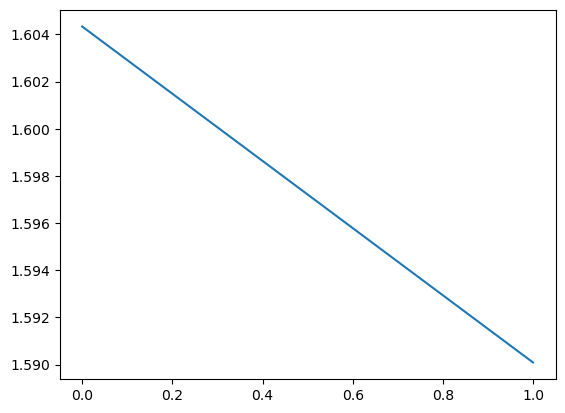

In [24]:
# you have to calculate losses arrayin Train part
plt.plot(list(range(len(losses))), losses)
plt.show()

## Evaluate model

In [5]:
def calc_accuracy(data, model):
  corrects = 0

  model.eval()
  for inputs, labels in tqdm(dataloaders[data]):
      inputs = inputs.to(device)
      labels = labels.to(device)
      
      with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, dim=1)
        corrects += torch.sum(preds == labels.data)
  return corrects.float() / dataset_sizes[data]

In [17]:
model.load_state_dict(best_model)

<All keys matched successfully>

In [26]:
# accuracy of training data
calc_accuracy('Training', model)

  0%|          | 0/87 [00:00<?, ?it/s]

tensor(0.8986, device='mps:0')

In [27]:
# accuracy of testing data
calc_accuracy('Testing', model)

  0%|          | 0/13 [00:00<?, ?it/s]

tensor(0.7868, device='mps:0')

# Saving Model

In [28]:
PATH = os.path.join(base_path, 'model.ci')
torch.save(model, PATH)

# Loading and eval Model

In [6]:
PATH = os.path.join(base_path, 'model.ci')

model_for_eval = torch.load(PATH)
model_for_eval.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [24]:
model_for_eval

In [8]:
# accuracy of training data by loadded model
calc_accuracy('Training', model_for_eval)

In [7]:
# accuracy of testing data by loadded model
calc_accuracy('Testing', model_for_eval)

  0%|          | 0/13 [00:00<?, ?it/s]

tensor(0.7868, device='mps:0')